# Assignment III
* Leoni Mota Loris

* At first, Load the data.

In [730]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.pyplot as plt
import subprocess
import os, glob
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [5]:
from collections import namedtuple

Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z', 'h', 'residue_seq_number'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())
Atom.parse_residue_seq_number = lambda string: int(string[23:30].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_x(string), Atom.parse_y(string), Atom.parse_z(string), 1,Atom.parse_residue_seq_number(string))

In [6]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return pd.DataFrame(atoms)

In [7]:
crambin = read_molecule('assets/1crn.pdb')
crambin[:10]

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,N,THR,17.047,14.099,3.625,1,1
1,CA,C,THR,16.967,12.784,4.338,1,1
2,C,C,THR,15.685,12.755,5.133,1,1
3,O,O,THR,15.268,13.825,5.594,1,1
4,CB,C,THR,18.170,12.703,5.337,1,1
5,OG1,O,THR,19.334,12.829,4.463,1,1
6,CG2,C,THR,18.150,11.546,6.304,1,1
7,N,N,THR,15.115,11.555,5.265,1,2
8,CA,C,THR,13.856,11.469,6.066,1,2
9,C,C,THR,14.164,10.785,7.379,1,2


## Question 1

## a)

* I) First we need to map the sequence of characters as in:

**TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATTCPGDYAN**
to a sequence of amino acids 

* II) And then, infer the position of each atom of the amino acid from a standard reference ($\alpha$ carbon) 


* III) Infer the position of multiple amino acids based on the peptide bond.

#### I) map the sequence of characters

In [8]:
aminoacid_mapping = {'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE',
                     'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE',
                     'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR'}
    
def map_to_aminoacids(sequence):
    return list(map(lambda char: aminoacid_mapping[char], sequence))

In [9]:
aminoacid_sequence = 'TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATTCPGDYAN'

In [10]:
aminoacids_names = map_to_aminoacids(aminoacid_sequence)

______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

In [11]:
def load_aminoacids():
    return list(map(lambda aminoacid_name: read_molecule('assets/' + aminoacid_name + '.pdb'), aminoacids_names))

In [12]:
aminoacids = load_aminoacids()

In [13]:
display(aminoacids[0])

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,,THR,0.080,-0.083,0.000,1,1
1,CA,,THR,1.539,-0.033,0.000,1,1
2,C,,THR,2.032,1.394,0.000,1,1
3,O,,THR,1.268,2.339,0.000,1,1
4,CB,,THR,2.116,-0.818,-1.226,1,1
5,OG1,,THR,1.743,-2.188,-1.162,1,1
6,CG2,,THR,3.654,-0.842,-1.361,1,1
7,1H,1,THR,-0.523,0.813,0.000,1,1
8,2H,2,THR,-0.461,-1.018,0.000,1,1
9,HA,,THR,1.904,-0.508,0.929,1,1


______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

#### III) Infer the position of multiple amino acids based on the peptide bond.


* After the nucleotilic attack the resonance delocalization of electrons in the peptide bond forces the creation of a plane where the atoms will be located (amide plan).

In [14]:
import numpy as np

def translation_matrix(delta_x, delta_y, delta_z, ref_x=.0, ref_y=.0, ref_z=.0):
    T = np.eye(4)
    T[0, -1], T[1, -1], T[2, -1] = delta_x - ref_x, delta_y - ref_y, delta_z - ref_z
    return T

def rotation_matrix(x_rotation_rad, y_rotation_rad, z_rotation_rad):
    Rx, Ry, Rz = np.eye(4), np.eye(4), np.eye(4)

    Rx[1, 1], Rx[1, 2], Rx[2, 1], Rx[2, 2] =\
        np.cos(x_rotation_rad), -np.sin(x_rotation_rad), np.sin(x_rotation_rad), np.cos(x_rotation_rad)
    
    Ry[0, 0], Ry[0, 2], Ry[2, 0], Ry[2, 2] =\
        np.cos(y_rotation_rad), np.sin(y_rotation_rad), -np.sin(y_rotation_rad), np.cos(y_rotation_rad)

    Rz[0, 0], Rz[0, 1], Rz[1, 0], Rz[1, 1] =\
        np.cos(z_rotation_rad), -np.sin(z_rotation_rad), np.sin(z_rotation_rad), np.cos(z_rotation_rad)

    return np.dot(np.dot(Rx, Ry), Rz)

def apply_transformation(transformation, df):
    df[['x', 'y', 'z', 'h']] = transformation.dot(df[['x', 'y', 'z', 'h']].T).T

def apply_rotation(transformation, df, atom_reference='N'):
    position = df[df.name == atom_reference].copy()
    apply_transformation(translation_matrix(-position.x, -position.y, -position.z), df)
    apply_transformation(transformation, df)
    apply_transformation(translation_matrix(position.x, position.y, position.z), df)


* Some utility functions for calculating the euclidean distance and the angle between two vectors:


$$distance = \sqrt{|(A - B)|}$$


$$cos(\alpha) = \frac{A \cdot B}{|A||B|}$$ 

In [15]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def l2_norm(p):
    return np.sqrt(np.sum(p ** 2))

def get_angle_rad(a, b, normal_reference):
    negative = np.all(np.dot(np.cross(a, b), normal_reference) < 0)
    angle = np.arccos(((a).dot(b))/(l2_norm(a) * l2_norm(b))) 
    angle = angle if not np.isnan(angle) else .0
    return angle if not negative else -angle

In [16]:
def get_desired_omega(current_aminoacid):
    return 0.0 if 'PRO' in current_aminoacid.aminoacid.values else 180.0

def get_desired_OCN_angle(current_aminoacid):
    return 123.0 if 'PRO' in current_aminoacid.aminoacid.values else 123.5

def get_desired_CNCa_angle(current_aminoacid):
    return 126.0 if 'PRO' in current_aminoacid.aminoacid.values else 122.0

def get_desired_bond_length(current_aminoacid):
    return 1.32 if 'PRO' in current_aminoacid.aminoacid.values else 1.33

________________________________
* This function infers the position at which the amide nitrogen should be, so we can find a translation of the "next" aminoacid.


* It return a position that is equals to the rotation of the oxygen inside the plane C$\alpha$-C-N, and uses the length of the peptide bond (1.33Å or 1.32Å) and the Angle (123.5 or 123).

In [17]:
def get_desired_nitrogen_location(aminoacid):
    alpha_carbon = aminoacid[aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    carboxyl_carbon = aminoacid[aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    oxygen_double_bonded = aminoacid[aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)

    CO = oxygen_double_bonded - carboxyl_carbon
    CA = alpha_carbon - carboxyl_carbon

    plane_normal = np.cross(CO, CA)
    plane_vector_basis = np.array([
        np.cross(CO, plane_normal) / l2_norm(np.cross(CO, plane_normal)), 
        CO / l2_norm(CO), 
        plane_normal / l2_norm(plane_normal)]).T

    CO_new_norm = CO * get_desired_bond_length(aminoacid) / l2_norm(CO)
    CO_new_norm_plane = np.linalg.solve(plane_vector_basis, CO_new_norm)[:2]
    
    rotation_angle = np.radians(get_desired_OCN_angle(aminoacid))
    rotation_angle_matrix = np.array(
        [[np.cos(rotation_angle), -np.sin(rotation_angle)], 
         [np.sin(rotation_angle), np.cos(rotation_angle)]])

    CN_plane = CO_new_norm_plane @ rotation_angle_matrix
    CN = np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array([CN_plane[0], CN_plane[1], 0]))
    N_desired = CN + carboxyl_carbon
    
    return np.pad(N_desired, (0, 1), 'constant', constant_values=1)

In [18]:
def get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C'):
    if terminal == 'C':
        alpha_carbon = previous_aminoacid[previous_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        oxygen_double_bonded = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
        C1 = oxygen_double_bonded - carboxyl_carbon
        C2 = alpha_carbon - carboxyl_carbon
    if terminal == 'N':
        last_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        C2 = last_carbon - nitrogen_amide
        C1 = carboxyl_carbon - nitrogen_amide
    return np.cross(C1, C2)

* The actual translations and rotations happens below:
    * We first translate the "next" aminoacid and then we do the rotations so the angles and distances can be as depicted below:
   
![assets/rotation.png](assets/pep.png)

* This method translates the `current_aminoacid` so its Nitrogen will be at the right spot for the peptide bond.

In [19]:
def translate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    desired_nitrogen_location = get_desired_nitrogen_location(previous_aminoacid)
    current_nitrogen_location = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z', 'h']].values.reshape(-1,)
        
    required_tranlation = desired_nitrogen_location - current_nitrogen_location
    
    required_tranlation_matrix = translation_matrix(required_tranlation[0], required_tranlation[1], required_tranlation[2])
    apply_transformation(required_tranlation_matrix, current_aminoacid)
    

* This method rotates the `current_aminoacid` so the normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ and the normal of the plane $C-N_{i+1}-C\alpha_{i+1}$ can be aligned.

In [20]:
def rotate_for_normal_alignment(previous_aminoacid, current_aminoacid, desired_normal):
    dimensions_range = [[1, 2], [0, 2], [0, 1]]
    for i, dimensions in enumerate(dimensions_range):
        differences = {}
        _desired_normal = desired_normal[dimensions]        
        nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)

        for angle_to_rotate in range(360):
            rotation_angles = np.zeros(3); rotation_angles[i] = np.radians(angle_to_rotate)
            alpha_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
            alpha_carbon = (rotation_matrix(*rotation_angles) @ np.append(alpha_carbon, 1))[:3]

            current_normal = np.cross(carboxyl_carbon - nitrogen_amide, alpha_carbon - nitrogen_amide)
            _current_normal = current_normal[dimensions]
            
            difference = l2_norm(np.cross(_current_normal, _desired_normal))
            difference += 0 if np.all(np.sign(_current_normal) == np.sign(_desired_normal)) else np.inf
            differences[np.radians(angle_to_rotate)] = difference

        apply_rotation(rotation_matrix(min(differences, key=differences.get), 0, 0), current_aminoacid)
    

def rotate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    omega = get_desired_omega(current_aminoacid)
    assert omega == 180.0 or omega == 0.0, 'Omega angle should be either 0 or 180!'
    previous_normal = get9_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C')
    rotate_for_normal_alignment(previous_aminoacid, current_aminoacid, previous_normal if omega == 0.0 else -previous_normal)

* This method rotates the `current_aminoacid` in the direction of a normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ stainding at the $N_i$ so the angle $C_i-N_{i+1}-C\alpha_{i+1}$ can be either 122 or 126 (*trans* / *cis*).

In [21]:
def rotate_for_CNCa_angle(previous_aminoacid, current_aminoacid):
    carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    alpha_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)

    NC = carboxyl_carbon - nitrogen_amide
    NCa = alpha_carbon - nitrogen_amide

    plane_normal = np.cross(NCa, NC)
    plane_vector_basis = np.array([
        np.cross(NC, plane_normal) / l2_norm(np.cross(NC, plane_normal)), 
        NC / l2_norm(NC),
        plane_normal / l2_norm(plane_normal)]).T

    current_CNCa_angle_rad = get_angle_rad(NC, NCa, -plane_normal)
    desired_CNCa_angle_rad = np.radians(get_desired_CNCa_angle(current_aminoacid))
    
    needed_rotation_rad = desired_CNCa_angle_rad - current_CNCa_angle_rad
    
    new_current_aminoacid = current_aminoacid.copy()
    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(plane_vector_basis, np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    apply_rotation(rotation_matrix(0, 0, needed_rotation_rad), new_current_aminoacid)

    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    new_alpha_carbon = new_current_aminoacid[new_current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    NC = carboxyl_carbon - nitrogen_amide
    NCa = new_alpha_carbon - nitrogen_amide

In [22]:
def dehydration(aminoacid1, aminoacid2):
    aminoacid1 = aminoacid1[~aminoacid1.name.isin(['OC', 'HC'])]    

__________________________
* Functions to verify the constrains regarding angles and distances in the amide plane.

In [23]:
def check_peptide_bond_length(previous_aminoacid, current_aminoacid):
    a = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    b = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    print('euclidean_distance for the peptide bond between %s and %s: %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], euclidean_distance(a, b)))
    
def check_OCN_angle(previous_aminoacid, current_aminoacid):
    c = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    n = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    o = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
    print('O-C-N Angle for the peptide bond between %s and %s:        %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], abs(180*get_angle_rad(o-c, n-c, (o-c))/np.pi)))

In [ ]:
aminoacids_df = load_aminoacids()
for i in range(1, len(aminoacids_df)):
    current_aminoacid = aminoacids_df[i]
    previous_aminoacid = aminoacids_df[i - 1]
    
    dehydration(previous_aminoacid, current_aminoacid)
    translate_for_peptide_bond(previous_aminoacid, current_aminoacid)
    rotate_for_peptide_bond(previous_aminoacid, current_aminoacid)

print('last aminoacid:')
display(current_aminoacid)

* We have all the atoms aligned accordingly. So, let's create string rows for the pdb.

In [24]:
def write_atom_to_file(atom_row, aminoacid_seq_number, fd):
    global atom_seq_number
    atom_seq_number += 1
    if 'H' not in atom_row[0]:
        atom_row.element = ''.join(filter(str.isalpha, atom_row[0]))[0]
        template_row =\
        'ATOM    '+\
        ('%d'%atom_seq_number).rjust(3)+\
        '  '+\
        ('%s'%atom_row[0]).rjust(3)+\
        ' '+\
        ('%s'%atom_row.aminoacid).rjust(3)+\
        ' A'+\
        ('%d'%aminoacid_seq_number).rjust(4)+\
        '    '+\
        ('%.3f'%atom_row.x).rjust(8)+\
        ('%.3f'%atom_row.y).rjust(8)+\
        ('%.3f'%atom_row.z).rjust(8)+\
        '  1.00  5.99           '+\
        ('%s\n'%atom_row.element)
        f.write(template_row)

In [26]:
atom_seq_number = 0

with open('assets/final_inferred_molecule.pdb', 'w') as f:
    for idx, aminoacid in enumerate(aminoacids_df):
        for atom_row in aminoacid.iterrows():
            write_atom_to_file(atom_row[1], idx, f)

with open("assets/final_inferred_molecule.pdb") as f:
    head = [next(f) for x in range(5)]
print('\n'.join(head))
print('...')

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________


b) 

In [37]:
def create_xyz(aminoacids_sequence, phi, psi, molecule_name='test'):
    molecules_description = [("""\\n%s %.1f %.1f""" % (a, p, ps)) for a, p, ps in zip(aminoacids_sequence, phi, psi)]
    molecules_description = ''.join(molecules_description)
    args = """%s\\n%s\\ncharmm22.prm%s\\n\\n\\n""" % (molecule_name, molecule_name, molecules_description)
    ps = subprocess.Popen(('printf', args), stdout=subprocess.PIPE)
    output = subprocess.check_output(('protein.exe'), stdin=ps.stdout)
    ps.wait()

In [846]:
def get_potential_energy(file_name):
    o = os.popen(
            r'printf "%s\ncharmm22\nE\n" | analyze.exe | sed -n "s/Total Potential Energy : //p"' % file_name
        ).read()
    return float(o.strip().split()[0].replace('D', 'e'))

In [847]:
def create_pdb(file):
    def add_atom_info(line):
        if len(line) > 14:
            atom = line[12:14].strip()[0]
            line = line + '  1.00  5.99           ' + atom
        return line
        
    ps = subprocess.Popen(('printf', "%s\\ncharmm22\\n" % file), stdout=subprocess.PIPE)
    output = subprocess.check_output(('xyzpdb.exe'), stdin=ps.stdout)
    ps.wait()
    lines = open(file + '.pdb').read().splitlines()
    new_lines = list(map(add_atom_info, lines))
    open(file + '.pdb', 'w').write('\n'.join(new_lines))

In [848]:
aminoacid_mapping = {'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE', 'Q': 'GLN', 'H': 'HIS', 
                     'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE', 'K': 'LYS',
                     'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR', 'M': 'MET'}
    
def map_to_aminoacids(sequence):
    return list(map(lambda char: aminoacid_mapping[char], sequence))

In [849]:
molecule_name = 'test'
# aminoacids_names = map_to_aminoacids('MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARFGDDGENL')
aminoacids_names = map_to_aminoacids('M')

l = len(aminoacids_names)
aminoacids_sequence, phi, psi = aminoacids_names, [0.0]*(l-1) + [0.03], [0.0]*(l-1) + [0.03]
for filename in glob.glob(molecule_name+'*'):
    try: os.remove(filename) 
    except: pass
create_xyz(aminoacids_sequence, phi, psi, molecule_name=molecule_name)
get_potential_energy(molecule_name)
# create_pdb(molecule_name)

-32.049

In [851]:
def compute_loss(solution):
    for filename in glob.glob(molecule_name+'*'):
        try: os.remove(filename) 
        except: pass
    create_xyz(aminoacids_sequence, solution[:len(solution)//2], solution[len(solution)//2:], molecule_name=molecule_name)
    return get_potential_energy(molecule_name)
#     create_pdb(molecule_name)

def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

def weighted_sample(arr, p, n):
    probs_and_elemnts = sorted([(np.random.random() * _p, element) for element, _p in zip(arr, p)],
                                key=itemgetter(0))[-n:]
    return list(map(lambda prob_elemnt: prob_elemnt[1], probs_and_elemnts))

def multi_point_crossover(ind1, ind2, n_cuts):
    # https://pdfs.semanticscholar.org/1325/cb27eececd1016c1f543b3977febbda1c0cd.pdf
    cuts = random.sample(range(ind1.n_dimensions), n_cuts)
    new_individue1 = copy.deepcopy(ind1)
    new_individue2 = copy.deepcopy(ind2)
    for begin_cut, end_cut in grouped(l, 2):
        new_individue1.individual_solution[begin_cut:end_cut] = ind2.individual_solution[begin_cut:end_cut]
        new_individue2.individual_solution[begin_cut:end_cut] = ind1.individual_solution[begin_cut:end_cut]
    return [new_individue1, new_individue2]


In [852]:
class Individue:
    def __init__(self, n_dimensions, dimension_range, loss_function):
        self.n_dimensions = n_dimensions
        self._dimension_range = dimension_range
        self._loss_function = loss_function
        self.individual_solution = self._get_initial_solution()
        self.loss = np.inf
    
    def _get_initial_solution(self):
        _solution = np.mean(np.abs(self._dimension_range)) * np.random.uniform(-1, 1, self.n_dimensions)
        return np.clip(_solution, *self._dimension_range)
    
    @property
    def solution(self):
        return self.individual_solution
    
    def update_loss(self):
        self.loss = self._loss_function(self.individual_solution)
        
    def crossover(self, another_individual):
        return multi_point_crossover(self, another_individual, 10)
    
    def mutate(self, sigma, mutation_probability=0.1):
        self.individual_solution +=\
            sigma * np.random.randn(self.n_dimensions) * (np.random.rand(self.n_dimensions) > mutation_probability)
        self.individual_solution = np.clip(self.individual_solution , *self._dimension_range)
        
class GeneticAlgorithm:
    def __init__(self, population_size, n_dimensions, dimension_range, loss_function, reselection_rate=0.8):
        self._population_size = population_size
        self._n_reselected = int(reselection_rate * population_size)
        self._population = [Individue(n_dimensions, dimension_range, loss_function) for _ in range(population_size)]
        self._best_so_far = []
    
    def update_population_fitness(self):
        return list(map(
            lambda individual: self._fitness_function(individual.solution), self._population
        ))
    
    def natural_selection(self, population_individual_loss):
        how_far_from_the_worst = (np.max(population_individual_loss) - population_individual_loss)
        return weighted_sample(self._population, how_far_from_the_worst, self._n_reselected)
        
    def crossover(self, parent1, parent2):
        return parent1.crossover(parent2)
    
    def mutate_population(self, sigma):
        list(map(lambda ind: ind.mutate(sigma), self._population))
        
    def get_population_individual_loss(self):
        return np.array(list(map(lambda ind: ind.loss, self._population)))
    
    def save_best_individue(self):
        best = min(self._population, key=lambda i:abs(i.loss))
        self._best_so_far.append(best)
        
    def _create_is_it_finished(self):
        iteration = 0
        previous_population_loss = None
        def is_it_finished(eps=0.1, max_iteration=100):
            nonlocal iteration, previous_population_loss
            
            current_population_loss = np.mean(self.get_population_individual_loss())
            iteration += 1
            previous_population_loss = current_population_loss
            self.save_best_individue()
            print('Iteration: %d, Loss: %.1f' % (iteration, current_population_loss))
            return iteration > max_iteration
        return is_it_finished

    def update_population_loss(self):
        list(map(lambda ind: ind.update_loss(), self._population))
        
    def create_children(self, n_of_children):
        children = [self.crossover(self._population[i], self._population[i+1]) for i in range(n_of_children // 2)]
        return [item for sublist in children for item in sublist]
        
        
    def optimize(self, max_iteration=500):
        is_it_finished = self._create_is_it_finished()
        while not is_it_finished(max_iteration=max_iteration):
            self.update_population_loss()
            self._population = self.natural_selection(self.get_population_individual_loss())
            new_children = self.create_children(self._population_size - len(self._population))
            self._population.extend(new_children)
            self.mutate_population(sigma=5)

In [853]:
g = GeneticAlgorithm(100, len(aminoacids_names)*2, (-180.0, 180.0), compute_loss)

In [854]:
g.optimize()

Iteration: 1, Loss: inf


ValueError: Sample larger than population or is negative

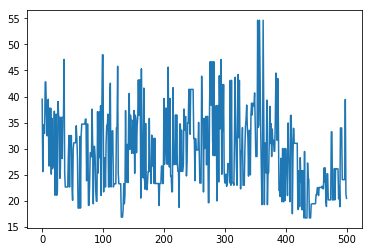

In [814]:
a = list(map(lambda a:a.loss, g._best_so_far))
plt.plot(np.log(a))

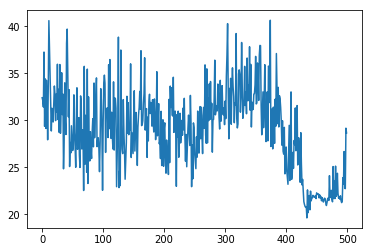

In [809]:
a = [117858505279749.7, 87994611481748.2, 43994399000000.0, 15229712000000000.0, 5615443000000.0, 876281993457545.5, 4496991000000.0, 761834880000000.0, 131703482262685.9, 1343980000000.0, 377389105760141.1, 430031219309000000.0, 20371960899947404.0, 1439394714901445.5, 45082141000000.0, 3433774982850.5, 38389460000000.0, 16106799901774.5, 8905228689835.8, 68398439000000.0, 410197520000000.0, 163632510000000.0, 10315072129873.5, 173842187110556.9, 25827877542938.5, 4162599280000000.0, 11542591314291.1, 289683193000000.0, 2930414000000.0, 4035391996000000.0, 2674705806626.2, 35470437617837.5, 1680286788922915.2, 19681857556094.4, 175084203338303.1, 61236287078.0, 1297386075573.6, 573167812838626.2, 9272871032919.2, 2358679000000.0, 38633828803394280.0, 175209850459000000.0, 1589453160741628.8, 15526072670026.6, 278791638592190.7, 77997610006.2, 1000448347526.3, 332706264282.8, 5976293499472.6, 1415191844686.1, 428327193403.6, 702692604509.5, 160115649754523.5, 3039230540756.5, 706348604825.7, 71862490457.1, 11573269202391.8, 339133023273644.8, 486939644410.8, 860204991403.2, 14229517817550.8, 266575813986.6, 70861400702.8, 143104099650467.4, 80365878084240.9, 504648276639.1, 3878882635374.0, 2491433514018.4, 6094591836.7, 3326094759659401.5, 99010150377.0, 18187827961191.2, 13892671938394.7, 42666232015.5, 2475941078398799.0, 12873715373.0, 129181392923823.5, 1077364290189.2, 141008492985.3, 3179370612068.5, 477191099601.3, 184099038417.5, 3054423731768.1, 12559970549992.8, 637572777904.1, 564673950807786.5, 1674234958987.1, 25626526865266.1, 131865250571843.7, 971549590560452.8, 646230759345.2, 1559153442444.7, 1671111128791.0, 537453130269.3, 45288713211.7, 1010869685162.1, 310808872455608.0, 92948089454475.6, 2729314236737.2, 6229676961.4, 9060359930648.2, 576351095177145.2, 1305635066240985.5, 547250748727375.3, 350834522060.9, 36299569010851.5, 36258070217212.9, 40815683576484.8, 1704611062050.6, 3949006150718337.5, 4434154798985.6, 6865772957000000.0, 5333389325756.4, 1557405839662.6, 25260276187770.1, 2062138521112.8, 503895729942.2, 637266552753857.8, 450454447569.1, 115972753192101.2, 107804275747396.3, 38907159854934.9, 9128477266.3, 251105771055.9, 8098719523667.2, 74469369869000000.0, 8291812515.4, 49488678057.9, 10212243079.9, 18890084638509300.0, 2546052001573.0, 500945816349.4, 308322963489.8, 96900997640716.8, 2996692845260.7, 459733777278.1, 20229626720.9, 142241746368.3, 1002029376195.8, 137632461583418.7, 2697427948670.7, 70067619901800.9, 2311707224328.0, 5772987673429.3, 3772001193472.3, 4337151154884123.0, 204058867710.9, 2907717600646.1, 908542865627.0, 309896165144.9, 15282620960226.1, 247155434509233.8, 405286232203.7, 3639461859210.2, 24601106091896.3, 2457217328123.2, 87878586889.5, 5141534115301.8, 18728007745135.9, 41136530000000.0, 231922367638659.5, 35143479573812.4, 17542786179513020.0, 6072782995642.0, 6668505000000.0, 10187302910115.9, 66556185751537.7, 182434927717665.1, 8267241334846810.0, 3781044966078.0, 19915036712440.4, 37188924000000.0, 206825178138.1, 14972579291597.5, 1187263522546.0, 79643191584472.1, 170579363000000.0, 21818183042457.6, 71317941000000.0, 58278679000000.0, 5758724000000.0, 95613430367386.0, 9794446000000.0, 3078679202963.1, 103598858664163.2, 17758855237411.3, 1362827416398.9, 6175213057362.5, 1877298271355043.5, 2061153400699.6, 9207479986017.9, 62884753793293.2, 881921051397.7, 1204978826466.7, 182644619050.1, 27767501000000.0, 86896050404.4, 575306375498.2, 11293519155944.7, 79501000000.0, 4227792766439.1, 8144147385099.6, 201194097530.4, 38515046110.5, 1309307990753.6, 390125362816.8, 170860475954.4, 33621160251.8, 98972012371795.4, 117968722704.8, 406570049081128.6, 41979712917325.8, 343254766000000.0, 18833915872425.1, 16888070079210.1, 1043085511038999.8, 2960173000000.0, 13975672987278.8, 28502536083327.9, 2940280724820.2, 9518219758.5, 19497757145812.9, 1876753006478.3, 28174828914424.8, 210120661143.0, 15401753967759.2, 22517916663494.7, 960969480683.5, 2013390071167.0, 10609520166600.5, 2190749836337.9, 39101088843406.0, 3859096572422.8, 110922306739522.6, 1969977886920.8, 137299754419.9, 2375560750845.9, 76135188403.8, 536710901760.5, 4556995000000.0, 18546995661118.3, 3594878610497.2, 730424442543.4, 150981127079328.4, 8514489028399.1, 9141623394.6, 782137991800.8, 21203487358.0, 8088306514536.4, 4970280810597.4, 307259244686.6, 147326761451.8, 62238647010.6, 1852025447979.5, 211509685683.8, 28453586402405.4, 1679593706429.3, 325625787840.9, 2815962728323.9, 46017072840971.2, 1504478170446.3, 42965672382783.0, 2102939124064.9, 309237722548.5, 17839533163231.7, 42670349000000.0, 4567746456210.3, 3885086340559235.0, 2232274294650.6, 928417497117.9, 2545130198617145.0, 961459893387.0, 111657329635523.9, 10309514000000.0, 512931331316534.8, 11713563152057.8, 662268580129674.8, 12857219861941.5, 65075536000000.0, 360836896249.3, 10772804451238.1, 11842617409040.5, 108204074373006.9, 6426001895620198.0, 19126612589489.6, 31948759000000.0, 50946922633468.2, 29130277000000.0, 506828073062710.3, 152685950000000.0, 14640093000000.0, 4228671540553.2, 749987455000000.0, 9653437000000.0, 23125639105778.0, 425777744000000.0, 45027116000000.0, 19240168000000.0, 39759303593218.5, 6735926264637.9, 82659988560935.8, 12730327000000.0, 1212191673000000.0, 11423969001535756.0, 312917557955251264.0, 314697183874125.6, 1492274000000.0, 319014732000000.0, 9942162000000.0, 927681992000000.0, 7034196654732.6, 549902775301689.7, 2833371183953426.5, 382249036000000.0, 134513263000000.0, 8252213000000.0, 65911723000000.0, 53734353603248.4, 108909683548131552.0, 13076016405378.4, 4758724000000.0, 7160857906270.6, 1499452258000000.0, 2289530966000000.0, 1401250698198157.5, 25431380310501.1, 140206868000000.0, 42121008160000000.0, 428157420000000.0, 13217410000000.0, 30276937101687.4, 98402229662893.4, 3327502621000000.0, 51864156000000.0, 221173800000000.0, 21451069925616.2, 8069317726944861.0, 86119004000000.0, 447541230000000.0, 86968412683970.9, 26717334851788660.0, 31163520000000.0, 4099026607000000.0, 5244699000000.0, 73907640714719.9, 33039660000000.0, 34676007759122.9, 172817956867633.8, 182511546000000.0, 461286032528425.6, 9597238190000000.0, 61091863639739.7, 67829129249360.8, 4767101680000000.0, 1429888639000000.0, 88534397000000.0, 10822153206000000.0, 30827632448656276.0, 30007411460000000.0, 49167724387733.5, 2284833106198.0, 24013433312765.9, 219354486957631.8, 4881175083467.7, 80692051807460.2, 3959328336432934.5, 18899634511347.6, 1110090340565.1, 8165583834312.9, 220580712510319.7, 1199116000000.0, 3408150752000000.0, 2946818452353491.0, 70474910000000.0, 449080268394537280.0, 657844810922.5, 6971701000000.0, 35819810000000.0, 510284667284.8, 43378150217177.8, 21071836073151.7, 918857000000.0, 100610567822647.1, 5694572792048.8, 12998082269218598.0, 411367822755697.9, 7457780657008.4, 356007728372446.8, 5270901943461.1, 145437181517854.2, 109440166608773.2, 41951104239267.6, 9712026019928.4, 760640571387.1, 10216600756806.3, 395342715372.5, 292736131420.7, 5044864197391.3, 35825112790.8, 54852186783.3, 623031391534.0, 51171662168.3, 23126121803.0, 11812187422.9, 263719355659.7, 6252419116812.4, 17613297661.4, 999980906901.0, 218909508568651.8, 19897467621.0, 36103181485.8, 351805012191.9, 64279863336.3, 1244979142280.4, 799206383739.8, 39800103416428.6, 420054789576.9, 2097356042532.2, 51255122457762.1, 92317366922.5, 1645815791891.5, 1610682834671.8, 597200903902.4, 14637736331.4, 2872144467504.3, 106204812038.2, 11079412767.7, 19821321586.6, 5551761287.8, 1867019074.8, 1392602860.1, 1120577589.2, 1015017325.1, 1088905571.9, 329662476.0, 6489471067.9, 575360592.0, 3082577008.3, 3592447669.9, 779350997.5, 5695477987.0, 2018943250.9, 2662002955.0, 2797353530.2, 3642116411.1, 3255527564.1, 3016126930.7, 2949747136.8, 3542321439.9, 2565764848.1, 4748046074.2, 4022904299.5, 4130392724.3, 4267510928.9, 2782981421.5, 3833452608.2, 2802638286.5, 3201598929.6, 2047685806.7, 2858337791.3, 2241375006.8, 1792273792.5, 2264628098.8, 2702459978.5, 2480107747.7, 1600082644.4, 1233003503.3, 1692928623.6, 2493491543.1, 2759171798.7, 2112689757.0, 29534961357.4, 2869002975.4, 2972447362.2, 6209395545.8, 2477350251.9, 1831676517.7, 77950262783.4, 2576276540.1, 16394024661.9, 2578491980.3, 81309015234.4, 3286580367.5, 3920569921.2, 38119913713.0, 4504684665.4, 2668095032.3, 3087454515.4, 2418412934.1, 3464230734.1, 2066496901.6, 1679784636.9, 1974875396.2, 23871634555.9, 11935293767.9, 384966677005.7, 7726142740.6, 7424247378.0, 4620016262177.5, 2787505997204.2]
plt.plot(np.log(a))

c) Compare RMSD